_Lambda School Data Science — Model Validation_ 

# Begin the modeling process

Objectives
- Train/Validate/Test split
- Cross-Validation
- Begin with baselines

## Get the Bank Marketing dataset

You have several ways you can get the dataset:

#### Kaggle
- Download from the [Kaggle competition page](https://www.kaggle.com/c/ds2-model-validation/data)
- Use the Kaggle API

#### GitHub
- Clone the [repo](https://github.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/tree/master/module-1-begin-modeling-process/bank-marketing)
- Download from the repo:

In [0]:
# !wget https://github.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/blob/master/module-1-begin-modeling-process/bank-marketing/train_features.csv
# !wget https://github.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/blob/master/module-1-begin-modeling-process/bank-marketing/train_labels.csv
# !wget https://github.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/blob/master/module-1-begin-modeling-process/bank-marketing/test_features.csv
# !wget https://github.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/blob/master/module-1-begin-modeling-process/bank-marketing/sample_submission.csv    

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/

!kaggle competitions download -c ds2-model-validation

Mounted at /content/drive
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/
  0% 0.00/424k [00:00<?, ?B/s]
100% 424k/424k [00:00<00:00, 29.1MB/s]
  0% 0.00/241k [00:00<?, ?B/s]
100% 241k/241k [00:00<00:00, 73.2MB/s]
  0% 0.00/142k [00:00<?, ?B/s]
100% 142k/142k [00:00<00:00, 43.1MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 32.5MB/s]


In [3]:
%cd bank-marketing

[Errno 2] No such file or directory: 'bank-marketing'
/content


In [5]:
!unzip train_features.csv.zip
!unzip test_features.csv.zip

Archive:  train_features.csv.zip
  inflating: train_features.csv      
Archive:  test_features.csv.zip
  inflating: test_features.csv       


In [6]:
import pandas as pd

train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')

train_features.shape, train_labels.shape, test_features.shape, sample_submission.shape

((30891, 20), (30891, 2), (10297, 20), (10297, 2))

In [9]:
train_features.head()

,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,20591,29,services,single,high.school,no,yes,yes,cellular,may,thu,10,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1
1,18343,54,management,married,university.degree,no,no,no,cellular,nov,tue,1,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8
2,32826,55,self-employed,married,unknown,unknown,no,no,cellular,jul,mon,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
3,29780,43,blue-collar,married,unknown,unknown,no,no,cellular,may,mon,6,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1
4,40736,54,blue-collar,married,basic.4y,no,yes,no,telephone,may,wed,5,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0


In [0]:
y_train = train_labels['y']
X_train = train_features.drop(columns='id')
X_test  = test_features.drop(columns='id')

In [11]:
y_train.value_counts(normalize=True)
#customers sign only around 10% of the time
#identify those customers!

0    0.887346
1    0.112654
Name: y, dtype: float64

## Train/Validation/Test split

How can we get from a two-way split, to a three-way split?

We can use the [**`sklearn.model_selection.train_test_split`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split the training data into training and validation data.

In [12]:
#train test, a two way split, isn't sufficient to compare multiple models
#or models with hyperparameters
#and cannot measure performance
#two way splits overfit

#methods: three way split, cross validation
#test is only brought back until the very end
#begin with baselines!
#get above score from guessing as fast as possible, then iterate
#then try to exceed human performance if realistic for problem

#we are given a halfway set as seperate dfs in the import. Split train again
#to get train and validate
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((23168, 19), (7723, 19), (23168,), (7723,))

Fit on the training set.

Predict and score with the validation set.

## Majority class baseline

Determine the majority class:

In [13]:
y_train.value_counts(normalize=True)

0    0.887042
1    0.112958
Name: y, dtype: float64

Guess the majority class for every prediction:

In [0]:
#baseline guess to exceed
#make list of zeroes that is length of yvalidate
majority_class = 0
y_pred = [majority_class] * len(y_val)

#### [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Baseline accuracy by guessing the majority class for every prediction:

In [15]:
#accuracy of baseline where we guess we had no subscriptions (all zeroes)
#very similar to normalized value_counts for 0
#accuracy isn't very useful
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.8882558591221028

#### [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

Baseline "ROC AUC" score by guessing the majority class for every prediction:

In [16]:
#roc_auc is 50%
#number range(0,1) where guess is 50%, >50% is worse than chance
#quality of predicted probabilities
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.5

## Fast first models

### Ignore rows/columns with nulls

This dataset doesn't have any nulls:

In [17]:
#fast model: ignore nulls, ignore nonnum, no feature engineering
#just use select_dtypes(np.number) and drop null cols
X_train.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

### Ignore nonnumeric features

Here are the numeric features:

In [18]:
import numpy as np
X_train.describe(include=np.number)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000
mean,39.981354,2.566342,963.340858,0.173860,0.083926,93.576054,-40.509418,3.620368,5166.949102
std,10.370713,2.751425,184.767191,0.498528,1.567770,0.576627,4.618191,1.735480,72.415082
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Here are the nonnumeric features:

In [19]:
X_train.describe(exclude=np.number)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,23168,23168,23168,23168,23168,23168,23168,23168,23168,23168
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,mon,nonexistent
freq,5857,13979,6904,18315,12139,19071,14731,7772,4852,19998


Just select the nonnumeric features:

In [0]:
X_train_numeric = X_train.select_dtypes(np.number)
X_val_numeric = X_val.select_dtypes(np.number)

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_numeric, y_train)

y_pred = model.predict(X_val_numeric)
roc_auc_score(y_val, y_pred)
#improved from chance
#this gives us a context for improvements caused by feature engineering and cleaning

0.5958437074548408

### With Scaler

In [22]:
#next model: scalar with logistic regression
#not time consuming

#don't print obnoxious scikit-learn warmings
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#FIT scale to train
X_train_scaled = scaler.fit_transform(X_train_numeric)
#APPLY scale to validation
#is already using transformed train std, mean
X_val_scaled = scaler.transform(X_val_numeric)

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_numeric, y_train)

y_pred = model.predict(X_val_scaled)
roc_auc_score(y_val, y_pred)
#worse roc_auc != worse
#better conclusion: isn't making much difference either way

0.5618036951579175

### Same, as a pipeline

In [23]:
#equivalent under-the-hood to above but as a different object
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
#fit pipeline on training (transforms scaler and log)
pipeline.fit(X_train_numeric, y_train)

y_pred = pipeline.predict(X_val_numeric)
roc_auc_score(y_val, y_pred)

0.5967837971142769

### Encode "low cardinality" categoricals

One-hot encode the "low cardinality" categoricals

In [24]:
#how many columns each category will one hot encode into
#you may choose to exclude high cardinality categories to early model
X_train.select_dtypes(exclude=np.number).nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

Install the Category Encoder library

If you're running on Google Colab:

```
!pip install category_encoders
```

If you're running locally with Anaconda:

```
!conda install -c conda-forge category_encoders
```

In [26]:
#category encoder includes auto nonnum one-hot
#was built for pd while sci-kit's eqivalents were not
!pip install category_encoders

import category_encoders as ce

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
roc_auc_score(y_val, y_pred)
#and so, without any feature engineering or hard work on the dataframe
#we have improved our baseline from chance to 11% more than chance

    100% |████████████████████████████████| 61kB 2.4MB/s 


0.608786303794817

In [27]:
#our prediction to publish to kaggle - predictions on test
print(X_val.shape) #have to have same cols
X_test.shape

(7723, 19)


(10297, 19)

In [29]:
print(pipeline.predict_proba(X_test).shape)
pipeline.predict_proba(X_test)[:, 1:]
#default - proba for each class (0 AND 1)
#we obviously only need proba 1

(10297, 2)


array([[0.11418808],
       [0.06808533],
       [0.44949309],
       ...,
       [0.06974964],
       [0.0164022 ],
       [0.04298217]])

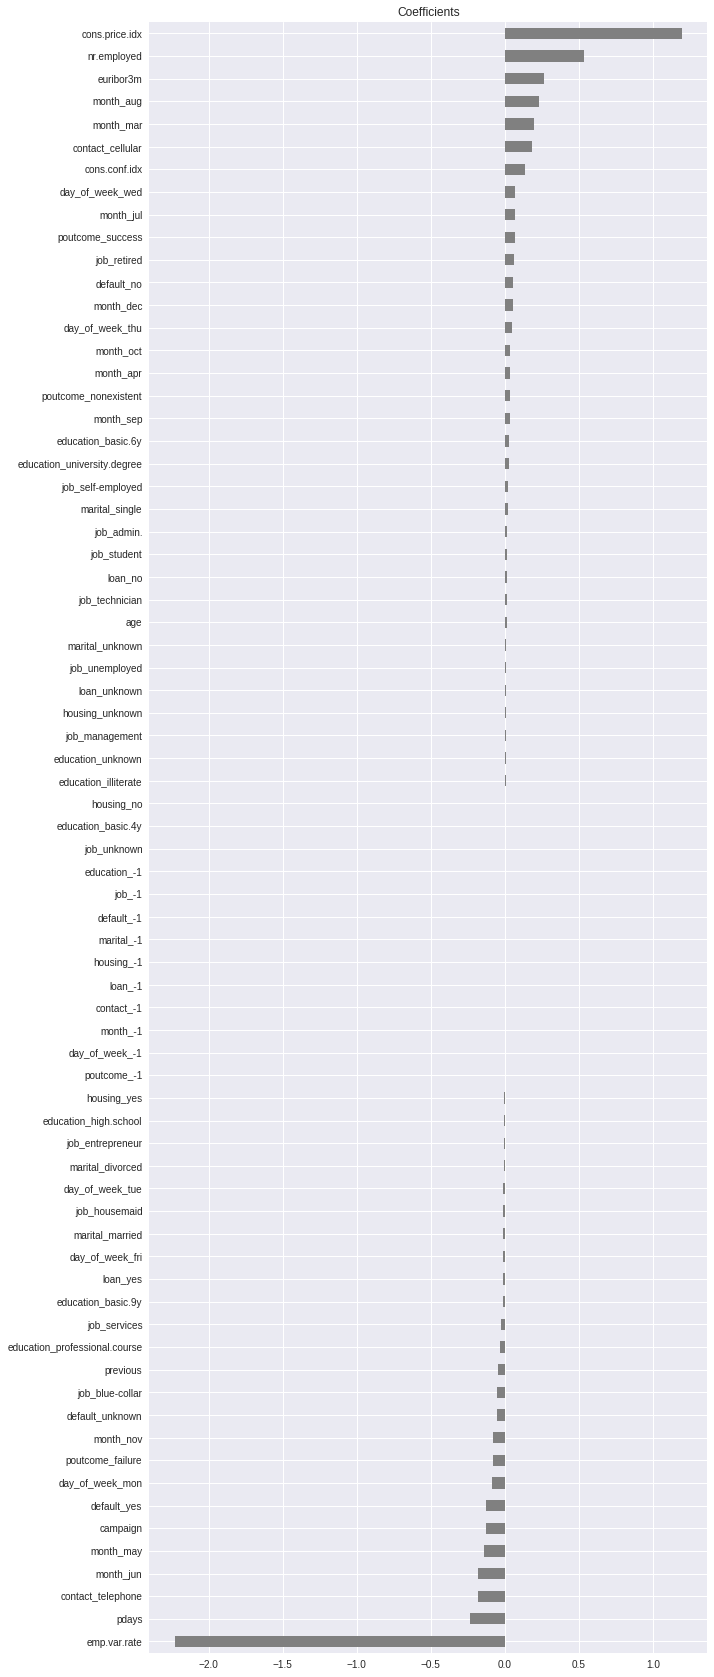

In [39]:
#visualize the coefs in pipeline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,30))
plt.title('Coefficients')

coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = pipeline.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');

In [32]:
submission = sample_submission.copy()
submission['y'] = pipeline.predict_proba(X_test)[:, 1:]
submission.head()

,id,y
0,12668,0.114188
1,44327,0.068085
2,26675,0.449493
3,11771,0.068661
4,38173,0.069908


In [0]:
#creating the csv file
submission.to_csv('tristagpaul-submission.csv', index=False)

In [35]:
!ls -lh *.csv

-rw-r--r-- 1 root root 101K Mar  4 17:18 sample_submission.csv
---------- 1 root root 1.3M Mar  4 14:02 test_features.csv
---------- 1 root root 3.7M Mar  4 14:02 train_features.csv
-rw-r--r-- 1 root root 242K Mar  4 17:18 train_labels.csv
-rw-r--r-- 1 root root 262K Mar  4 19:11 tristagpaul-submission.csv


In [37]:
#submit
import kaggle
kaggle.api.competition_submit

<bound method KaggleApi.competition_submit of <kaggle.api.kaggle_api_extended.KaggleApi object at 0x7f74512dafd0>>

In [33]:
submission.y.describe()

count    10297.000000
mean         0.112395
std          0.144851
min          0.005253
25%          0.040384
50%          0.060295
75%          0.093629
max          0.902701
Name: y, dtype: float64